In [2]:
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torch.utils.data as data_utils
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn import metrics

from tqdm.notebook import tqdm as tqdm
import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np
import shutil
import pickle
import os

import cv2

In [3]:
dataset_name = "cifar"

if dataset_name == "cifar":
    dataset_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\data\cifar"
    
if dataset_name == "mnist":
    dataset_path = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\data\mnist" 

In [4]:
with open(os.path.join(dataset_path,"datasets","cifar-10-batches-py\\batches.meta"), 'rb') as fp:
    label_names = pickle.load(fp)['label_names']

In [5]:
with open(os.path.join(dataset_path,"datasets",dataset_name+"_labels"), 'rb') as fp:
    targets = pickle.load(fp)

targets = np.array(targets) ##new

## Moving Dataset paths

In [6]:
# for i in label_names:

#     os.makedirs(os.path.join(dataset_path,"reconst_class_images",i))

In [7]:
# for i in range(10000):

#     tg = targets[i]
#     shutil.copy(os.path.join(dataset_path,"reconstructed_images",str(i)+".png"),os.path.join(dataset_path,"reconst_class_images",label_names[tg],str(i)+".png"))
#     # print(os.path.join(dataset_path,"reconstructed_images",str(i)+".png"),os.path.join(dataset_path,"reconst_class_images",label_names[tg],str(i)+".png"))
    

## Loading Dataset

### Reconstructed Images

In [8]:
input_raw_list = []

In [9]:
for i in range(10000):

    img = cv2.imread(os.path.join(dataset_path,"reconstructed_images",str(i)+".png"),cv2.IMREAD_GRAYSCALE)
    input_raw_list.append(img)


In [10]:
input_reconst = np.array(input_raw_list)

### Original Images

In [11]:
file = r"C:\Users\ayush\OneDrive\Desktop\UoE\Dissertation\Implicit Networks\data\cifar\datasets\cifar_10K_dataset.pt"

In [12]:
input_dataset = torch.load(file)

In [13]:
input_reconst_list = []

for i in input_dataset:

    input_reconst_list.append(i[0].numpy())

In [14]:
input_org = np.array(input_reconst_list)

## Classifier

In [26]:
def classifier(input_array,tg,c_name,d_name,scale,pca_val = None):

    input_data = input_array
    
    if scale == True:
        
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)

    if pca_val != None:

        pca = PCA(n_components=pca_val)
        input_data = pca.fit_transform(input_data)
        

    x_train, x_test, y_train, y_test = train_test_split(input_data, tg, test_size=0.25, random_state=42)

    if c_name == "logit":

        logisticRegr = LogisticRegression(solver = 'sag',penalty = 'l2')
        logisticRegr.fit(x_train, y_train)

        y_pred = logisticRegr.predict(x_test)

        # Use score method to get accuracy of model
        test_accuracy = logisticRegr.score(x_test, y_test)
        train_accuracy = logisticRegr.score(x_train,y_train)
        
    if c_name == "forest":
        
        rf = RandomForestClassifier(n_estimators=300,max_depth=14)
        rf.fit(x_train, y_train)    

        y_pred = rf.predict(x_test)
        y_pred_train = rf.predict(x_train)

        test_accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, y_pred_train)
    
    # Metrics

    # print("Test accuracy",test_accuracy,"Train accuracy",train_accuracy)
            
    cm = metrics.confusion_matrix(y_test, y_pred) # Confusion matrix

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5,cbar=False, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Test Accuracy: {0} / Train Accuracy: {1}'.format(test_accuracy,train_accuracy)
    note = 'Confusion matric for {0} with PCA (={1}) on {2} dataset'.format(c_name,pca_val,d_name)
    plt.figtext(0.5, 0.01,note, ha="center", fontsize=15,color ="black") #bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.title(all_sample_title, size = 15);
    
    plt.savefig(os.path.join(dataset_path,"plots\\metrics",note+".pdf"))
    plt.show()
    return 0

In [27]:
input_reconst = input_reconst.reshape([10000,28*28])
input_org = input_org.reshape([10000,28*28])


In [28]:
# classifier(input_array,targets,'forest',True,None)

------- Original Image ----------------


c:\MLAI\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


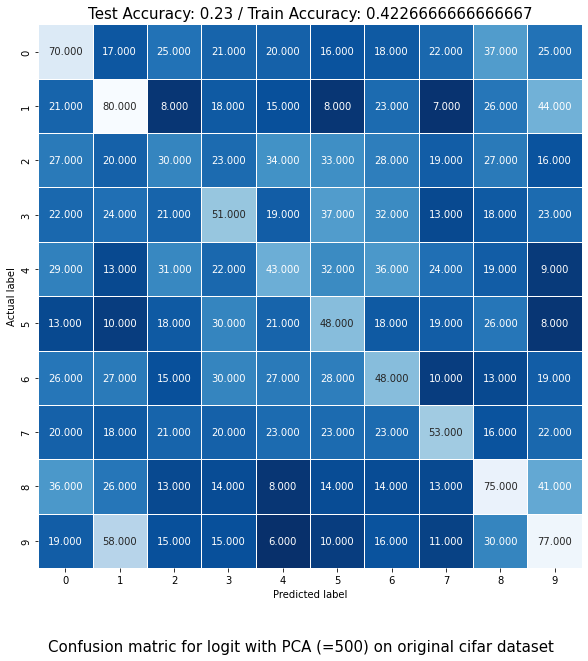


 ------- Reconstructed Image ----------------


c:\MLAI\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


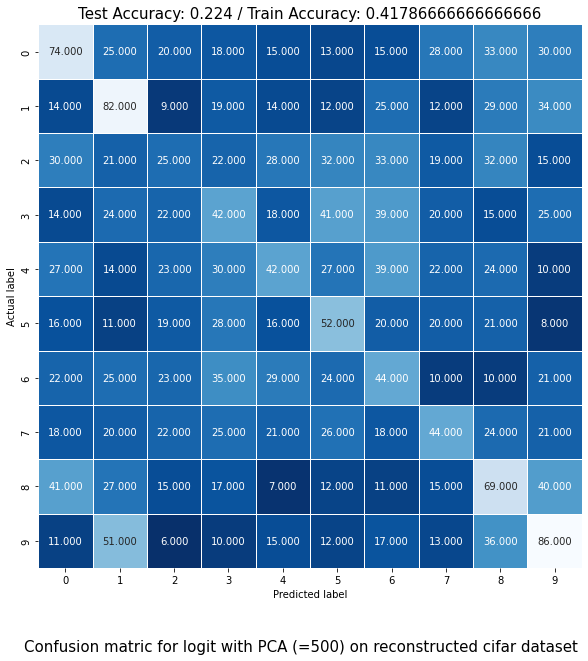

0

In [29]:
pca_features = 500

print( "------- Original Image ----------------")
classifier(input_org,targets,'logit',"original "+dataset_name,True,pca_features)
print("\n", "------- Reconstructed Image ----------------")
classifier(input_reconst,targets,'logit',"reconstructed "+dataset_name,True,pca_features)